# A1: Data Curation
Karl Stavem  
ID:  1978397

---
> TL;DR: The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1, 2008 through August 30, 2020.
---

### Step 1: Gathering the data

First, import all libraries that might be helpful in aquiring and processing the data.

In [1]:
# import libraries
import os
import requests
import json
import pandas as pd
import numpy as np

Since there are two separate APIs, define each endpoint separately.

In [2]:
# set the API endpoints

# from January 2008 to July 2016
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

# from May 1st, 2015
endpoint_new = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

Before making any calls to the API, ensure the header information is set for each call.

In [3]:
# set headers for API calls
headers = {
    'User-Agent': 'https://github.com/stavem',
    'From': 'kstavem@uw.edu'
}


Because the parameters are similiar in each API but the syntax is slightly different between the two, the method below allows users to switch back and forth between them quickly.   For this exercise, since most parameters remain constant, the only parameters that need to change are the version and access site.  The start and end date could also remain constant since this exercise pulls all available dates within each API, though they will be specified later. 

In [4]:
def assign_parameters(is_legacy_version, access, project = "en.wikipedia.org", 
                      agent = "user", granularity = "monthly", 
                      start = '2008010100', end =  '2020090100'):
    """
    Input:  Access and is_legacy_version
            For legacy API set is_legacy_version = 1
            If querying legacy API:  Valid access inputs in ['dektop-site', 'mobile-site']
            If querying non-legacy API:  Valid access in ['desktop', 'mobile-web', 'mobile-app']
        
    Output:  Parameters for use in API query
    """
    
    if is_legacy_version:
                      params = {"project" : project,
                                "access-site" : access,
                                "granularity" : granularity,
                                "start" : start,
                                "end" : end
                               }

    else:
                      params = {"project" : project,
                                "access" :access,
                                "agent" : agent,
                                "granularity" : granularity,
                                "start" : start,
                                "end" : end
                               }
    return params

The method below will pass all parameters into a wikipedia API call and return the response.  This method also raises any errors from poorly structered queries.

In [5]:
def api_call(endpoint,parameters):
    """
    Conduct API calls to Wikiepdia
    Inputs:  Wikipedia API Endpoint, Parameters for API call
    Output:  Response in JSON format
    """
    
    # try to call the api
    try:
        call = requests.get(endpoint.format(**parameters), headers=headers)
        call.raise_for_status()
        
    # Alert user of any errors
    except requests.exceptions.HTTPError as error:
        print(error)
    
    response = call.json()
    return response

Next, use the `api_call` method multiple times to save the data.   Since there are 3 sites for the newest version of the API and 2 sites for the legacy version, these values will be stored in a list to iterate through them.   For each site the following code will define the parameters, call the API, and save the results.

In [6]:
# set directory to work with all saved files
directory_path = '/home/jovyan/data-512/data-512-a1/'

# store list of all saved JSON files to access later
files_list = []



# define the 3 sites we'll be looking at for new API
new_sites = ['desktop', 'mobile-web', 'mobile-app']

# query all sites for the new API, save the results
for site in new_sites:
    
    # call the API
    params = assign_parameters(is_legacy_version = 0, access = site, start = '2015070100', end = '2020080100')
    data = api_call(endpoint_new, params)
    
    # name the file, store location in a list
    filename = 'pageviews_{}_201507-202008.json'.format(site)
    files_list.append(directory_path + filename)
    
    # write to file
    with open(directory_path + filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

        

# define the 2 sites we'll be looking at for the legacy API
legacy_sites = ['desktop-site', 'mobile-site']        
        
# query all sites for the old API, save the results
for site in legacy_sites:
    
    # call the API
    params = assign_parameters(is_legacy_version = 1, access = site, start = '2007120100', end = '2016080100')
    data = api_call(endpoint_legacy, params)
    
    # name the file, store location in a list
    filename = 'legacy_pagecounts_{}_200712-201607.json'.format(site)
    files_list.append(directory_path + filename)
    
    # write to file
    with open(directory_path + filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    
    


### Step 2: Processing the data

The code below iterates through five files that have been collected and combines them into one big JSON file.

In [7]:
# combine all json files into one json file
combined_json_file=[]

for file in files_list:
    with open(file) as f:
        combined_json_file.append(json.load(f))

The code below will convert that large JSON file into a pandas data frame to make it easier to manipulate.  It also drops the unnecessary columns.

In [8]:
# convert JSON file into pandas dataframe
df = pd.DataFrame()
for i in range(len(combined_json_file)):
    df=df.append(pd.json_normalize(combined_json_file[i]['items']))

# drop the unnecessary columns
df.drop(['project', 'granularity', 'agent'], axis=1, inplace = True)

Since the assignment instructions specify the column names, the code below renames some of the columns now to make aggregation easier.

In [9]:
# combine all the mobile traffic from the newer API into one category
df.loc[df['access'].isin(['mobile-app', 'mobile-web']),'access'] = 'pageview_mobile_views'

# change the desktop value
df.loc[df['access'].isin(['desktop']),'access'] = 'pageview_desktop_views'

# change the legacy mobile name
df.loc[df['access-site'].isin(['mobile-site']),'access-site'] = 'pagecount_mobile_views'

# change the legacy desktop name
df.loc[df['access-site'].isin(['desktop-site']),'access-site'] = 'pagecount_desktop_views'


The code below will combine the `access` and `access-site` columns into a new column called `source` and drop the old, unecessary columns.

In [10]:
# # create a new source column to track
df['source'] = np.where(df["access"].isnull(), df["access-site"], df["access"] )

# #drop old columns
df.drop(['access', 'access-site'], axis=1, inplace = True)

Using string manipulation, the following code extracts the `year` and `month` values from the timestamp column.  Once complete, the `timestamp` column is dropped.

In [11]:
# extract the year and the month from the timestamp column
df['year'] = df['timestamp'].str[:4]
df['month'] = df['timestamp'].str[4:6]

# drop the timestamp column as it is unnecessary
df.drop(['timestamp'], axis=1, inplace = True)


Since some of the totals are labeled `count` and some are labeled `views`, the code below combines these into a single column called `views` and drops the unnecessary `count` column.   It also replaces any `NA` values with 0.

In [12]:
# get rid of NA in total columns
df['views'] = df['views'].fillna(0)
df['count'] = df['count'].fillna(0)

# add totals
df['views'] = df['views']+df['count'].fillna(0)

# drop the count column
df.drop(['count'], axis=1, inplace = True)

The assignment instructions specify a single .csv file with the following columns:

* year / YYYY
* month / MM
* pagecount_all_views / num_views
* pagecount_desktop_views / num_views
* pagecount_mobile_views / num_views
* pageview_all_views / num_views
* pageview_desktop_views / num_views
* pageview_mobile_views / num_views

The code below gets close to this format by pivoting the data.   It keeps `year` and `month` as the index and aggregates across other columns.

In [13]:
# pivot the data and aggregate according the the instructions

df_pivoted = pd.pivot_table(df, values='views', index=['year', 'month'],
                    columns=['source'], aggfunc=np.sum, fill_value=0)

# Formatting - make sure year and month repeat down each row
df_pivoted.reset_index(inplace=True)
df_pivoted.columns.name = None

Once the data pivoted in the correct way, two additional columns are added to track the total traffic across both APIs.

In [14]:
# add all traffic for totals
df_pivoted['pagecount_all_views'] = df_pivoted['pagecount_desktop_views'] + df_pivoted['pagecount_mobile_views']
df_pivoted['pageview_all_views'] = df_pivoted['pageview_desktop_views'] + df_pivoted['pageview_mobile_views']

The code below rearranges the order of the columns to match the order specified in the assignment.   It also sorts the rows by `year` and `month` for clarity.

In [15]:
# rearrange columns and order to match assignment
df = df_pivoted[['year','month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 
                'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']].sort_values(by=['year', 'month'])

# previw results
display(df)

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2998331524,2998331524,0,0,0,0
1,2008,01,4930902570,4930902570,0,0,0,0
2,2008,02,4818393763,4818393763,0,0,0,0
3,2008,03,4955405809,4955405809,0,0,0,0
4,2008,04,5159162183,5159162183,0,0,0,0
...,...,...,...,...,...,...,...,...
147,2020,03,0,0,0,8098768829,3412498274,4686270555
148,2020,04,0,0,0,9304114554,3798372613,5505741941
149,2020,05,0,0,0,8309793710,3078093615,5231700095
150,2020,06,0,0,0,7295303813,2721328557,4573975256


Since the `timestamp` column was removed, the code below creates a new index using the `year` and `month` columns.  This makes charting the data easier in subsequent steps.

In [16]:
# set the index to month/date for easier graphing
df = df.set_index(pd.to_datetime(df[['year','month']].assign(day=1)))

The code below saves the file as: `en-wikipedia_traffic_200712-202008.csv`.

In [17]:
# write file
df.to_csv('en-wikipedia_traffic_200712-202008.csv', index=False)

### Step 3: Analyze the data

The code below reproduces the chart in the assignment instructions using `matplotlib`.

In [18]:
# import libraries
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# magic code for viewing plots using jupyter notebooks:
%matplotlib inline 

The code below produces a chart, handling the following criteria:

* In order to match the scale in the assignment, the totals need to be divided by 1,000,000.  
* Each line must change it's style when it hits `2015-05-01`.  
* Since several lines are created, a custom legend must be built that contains only the key elements.
* In addition, a caption must be created to clarify the line styles.

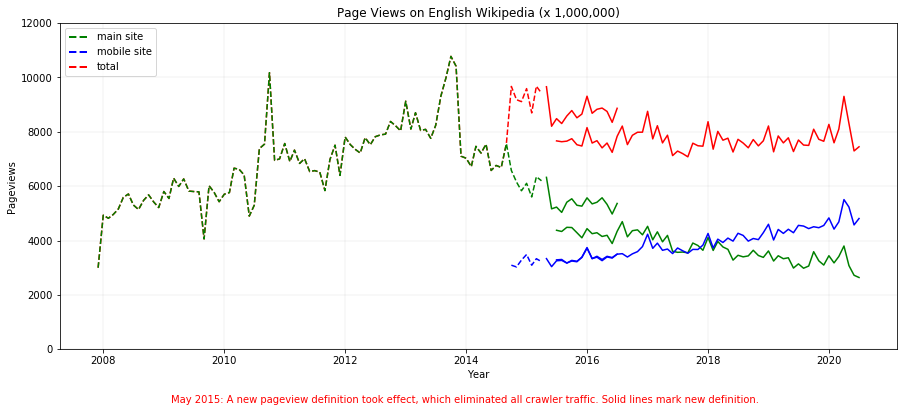

In [19]:
# give the figure landscape orientation, set size
fig, ax = plt.subplots(figsize=(15, 6))


# Set plot title , axes labels/range, gridlines
ax.set(title = "Page Views on English Wikipedia (x 1,000,000)")
ax.set(xlabel = "Year")
ax.set(ylabel = "Pageviews")
plt.ylim(0,12000)
plt.grid(color='gray', linestyle='-', linewidth=.1)

# add lines to the plot (divide by 1,000,000 for scale) - need to change line style at 05/15
ax.plot((df[df.index < '2015-05-01'][['pagecount_all_views']+['pageview_all_views']]/1000000).where((df[['pagecount_all_views']+['pageview_all_views']]>0)), '--r')
ax.plot((df[df.index >= '2015-05-01'][['pagecount_all_views']+['pageview_all_views']]/1000000).where((df[['pagecount_all_views']+['pageview_all_views']]>0)), '-r')


ax.plot((df[df.index >= '2015-05-01'][['pageview_desktop_views']+['pagecount_desktop_views']]/1000000).where(df[['pageview_desktop_views']+['pagecount_desktop_views']]>0), '-g')
ax.plot((df[df.index < '2015-05-01'][['pageview_desktop_views']+['pagecount_desktop_views']]/1000000).where(df[['pageview_desktop_views']+['pagecount_desktop_views']]>0), '--g')


ax.plot((df[df.index >= '2015-05-01'][['pageview_mobile_views']+['pagecount_mobile_views']]/1000000).where(df[['pageview_mobile_views']+['pagecount_mobile_views']]>0), '-b' )
ax.plot((df[df.index < '2015-05-01'][['pageview_mobile_views']+['pagecount_mobile_views']]/1000000).where(df[['pageview_mobile_views']+['pagecount_mobile_views']]>0), '--b')


# write the caption at the bottom of the page
caption = 'May 2015: A new pageview definition took effect, which eliminated all crawler traffic.\
 Solid lines mark new definition.'

# add caption to figure
fig.text(.5, .001, caption, ha='center', c = 'r')

# since we have multiple lines, manually define legend elements
legend_elements = [Line2D([0], [0], color='g', lw=2, label='main site', linestyle='--'),
                   Line2D([0], [0], color='b', lw=2, label='mobile site', linestyle='--'),
                   Line2D([0], [0], color='r', lw=2, label='total', linestyle='--')]

# add the legend to the plot with a border in upper left corner
ax.legend(handles = legend_elements, loc='upper left', frameon=True)

plt.show()

Save the image as a png file.

In [20]:
# save the file once all steps complete
fig.savefig('FinalGraph.png', quality = 95, pad_inches = .5)

---
### Submit the assignment

The github link for this assignment can be found here:   <a href="https://github.com/stavem/data-512/tree/main/data-512-a1">here</a>.